### Procedure for Evaluation : English Samples - Smriti

* Open taxon, collector, geography gt-labels and the gpt-resized-results 
* Check if gpt-file has attribute of scientificname, collected by / recorded by, country/locality
* Make count of all comparable files (some don't have valid responses - ignore these)
* Check match of the gt with produced labels (if produced label in gt) or perhaps some better match method (similarity measures)
* Count number of matches with some threshold value ->80% match 
* Measure of accuracy 

In [1]:
#installations necessary
# pip install taxonerd
# pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_biobert-1.0.2.tar.gz
# pip install tqdm
# pip install seaborn

In [2]:
#import statements
import os
import pandas as pd
import numpy as np
import re
from taxonerd import TaxoNERD
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### Convert ground truth labels into Dataframe for easy access

In [6]:
gt = pd.DataFrame(columns=['ID', 'Taxon', 'Collector', 'Geography'])

print(os.getcwd())
# os.chdir("gt_labels/")
os.chdir("../ml-herbarium-data/scraped-data/drago_testdata/gt_labels")

with open("taxon_gt.txt", 'r') as tf, open("collector_gt.txt", 'r') as cf, open("geography_gt.txt", 'r') as gf:
    t = []
    c = []
    g = []
    id = []
    for line in tf:
        id.append(line.rstrip('\n').split(":")[0])
        t.append(line.rstrip('\n').split(":")[1].lstrip())

    for line in cf:
        c.append(line.rstrip('\n').split(":")[1].lstrip())

    for line in gf:
        g.append(line.rstrip('\n').split(":")[1].lstrip())

/projectnb/sparkgrp/ml-herbarium-grp/fall2023


In [7]:
gt['ID'] = id
gt['Taxon'] = t
gt['Collector'] = c
gt['Geography'] = g

In [8]:
gt.head()

,ID,Taxon,Collector,Geography
0,1697659851,Euphrasia officinalis,Nazarov M. I.,Russian Federation
1,2573258025,Bryoerythrophyllum recurvirostrum,M. Morgan [?],United States of America
2,2597666444,Carduus tenuiflorus,Lortet Clémence,France
3,1931288980,Agoseris parviflora,H. H. Rusby,United States of America
4,1930241969,Spiraea canescens,R. Pinkus,United States of America


In [9]:
gt = gt.dropna(axis=1)

In [10]:
#Checking for duplicates
ids = gt["ID"]
gt[ids.isin(ids[ids.duplicated()])].sort_values("ID")

,ID,Taxon,Collector,Geography


### Extract results from Azure model into pandas dataframe

In [11]:
#Load the azure vision results
print(os.getcwd())
os.chdir('/projectnb/sparkgrp/ml-herbarium-grp/fall2023/AzureVisionResults/')

folder_path = os.getcwd()
result_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('txt'))]

#checking for duplicate files
print(len(result_files)==len(set(result_files)))
rows = []
for i in result_files:
    # print(i)
    # break
    f = open(i, 'r')
    lines = f.readlines()
    new_row=[]
    taxon_res=""
    geo_res=""
    col_res=""
    
    for line in lines:
        if "scientificname\":" in line.lower():
            taxon_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
        if "country\":" in line.lower():
            geo_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
        if "collectedby\":" in line.lower() or "recordedby\":" in line.lower() or "collector\":" in line.lower():
            # print(line.strip().split(":"))
            col_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
            
    new_row = [i.replace('.txt',''),taxon_res,col_res,geo_res]
    rows.append(new_row)
    f.close()


/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/gt_labels
True


In [12]:
rt = pd.DataFrame(rows, columns=['ID', 'rTaxon', 'rCollector', 'rGeography'])

In [13]:
rt.isnull().values.any()

False

In [14]:
np.where(pd.isnull(rt))

(array([], dtype=int64), array([], dtype=int64))

In [15]:
np.where(rt.map(lambda x: x == ''))

(array([ 37,  53,  54,  55,  64,  71,  72,  73,  94, 110, 122, 137, 148,
        153, 181, 186]),
 array([2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]))

### Noting down empty values

In [16]:
rt[rt['rTaxon'] == '']['ID']

71    1999143240
73    1455174725
Name: ID, dtype: object

In [17]:
rt[rt['rCollector'] == '']['ID']

37     1318373170
53     2848503382
54     2625898343
55     3005670412
64     3341239321
72     2236116492
94     1999154508
110    2625876902
122    2848440467
137    3459889344
148    2900461439
153    3092956655
181    1928370989
186    1702827727
Name: ID, dtype: object

In [18]:
rt[rt['rGeography'] == '']['ID']

Series([], Name: ID, dtype: object)

## Comparison with Ground Truth Labels

### Creating a combined Dataframe for easy comparison between columns

In [19]:
new_df = (pd.merge(gt, rt, on='ID'))

In [20]:
new_df.head()

,ID,Taxon,Collector,Geography,rTaxon,rCollector,rGeography
0,1931124118,Suaeda nigra,S. Watson,United States of America,Suaeda torreyana Wats.,Sereno Watson,United States
1,1426171668,Albizia niopoides,"Jorgensen, P.",Paraguay,Withacolabium Haslevi Chvad,Prof. Pedro Jorgensen,Paraguay
2,2512855384,Clematis ladakhiana,W. N. Koelz,India,Clematis ladakhiana Grey-Wilson,Walter Koelz,India
3,1318293083,Cordia sulcata,W. L. Abbott,Dominican Republic,Verben,W. L. Abbott,Dominican Republic
4,3005670412,Oplismenus burmanni,C. Robinson,Indonesia,Hippogrostis amboinica,,United States


In [21]:
np.where(pd.isnull(new_df))

(array([], dtype=int64), array([], dtype=int64))

In [22]:
np.where(new_df.map(lambda x: x == ''))

(array([  4,  13,  15,  21,  41,  61,  76,  86,  88,  98, 142, 150, 151,
        167, 193, 195]),
 array([5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5]))

In [23]:
len(new_df)

224

#### Observed variations in the word USA - so converting all variations to the standard of Ground Truth label

In [24]:
##Replacing all USA variations with one label

# for i in new_df['rGeography']:
#     if i=="USA" in i or "United States" in i:

new_df['rGeography'] = new_df['rGeography'].apply(lambda i: "united states of america" if i.lower() in ["usa","united states","us"] else i)

### Removing punctuation and lower-casing all text as a pre-processing step

In [26]:
p = re.compile(r'[^\w\s]+')

for i in new_df.columns:
    if i=="ID":
        continue
    new_df[i] = new_df[i].str.lower()
    new_df[i] = [p.sub('', x) for x in new_df[i].tolist()]

In [27]:
new_df.head()

,ID,Taxon,Collector,Geography,rTaxon,rCollector,rGeography
0,1931124118,suaeda nigra,s watson,united states of america,suaeda torreyana wats,sereno watson,united states of america
1,1426171668,albizia niopoides,jorgensen p,paraguay,withacolabium haslevi chvad,prof pedro jorgensen,paraguay
2,2512855384,clematis ladakhiana,w n koelz,india,clematis ladakhiana greywilson,walter koelz,india
3,1318293083,cordia sulcata,w l abbott,dominican republic,verben,w l abbott,dominican republic
4,3005670412,oplismenus burmanni,c robinson,indonesia,hippogrostis amboinica,,united states of america


Now we move to the Evaluation stage - We have analyzed Taxon, Collector and Geography (country) as a part of this semester's work individually and also compared how they do with respect to one another. Please note that the evaluation metrics used for the 3 labels may not be the same. 

## Taxon Metrics

### 1. Accuracy

In [28]:
# Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    if row['Taxon'].lower() in row['rTaxon'].lower():
        c+=1

In [29]:
print(c)

101


In [30]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 45.089285714285715%


In [31]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rTaxon'].lower() for x in row['Taxon'].lower().split()):
        c+=1

In [32]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 79.01785714285714%


In [33]:
tax_acc = acc

In [34]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Taxon'].lower().split()).issubset(set(row['rTaxon'].lower().split()))):
        c+=1

In [35]:
print(c)

101


In [36]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 45.089285714285715%


## 2. Extended Approach : Utilizing TaxoNERD and Cosine Similarity for predicting closest taxons

In [37]:
! nvidia-smi

Sat Dec  9 23:00:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:18:00.0 Off |                    0 |
| N/A   45C    P0              53W / 300W |      0MiB / 16384MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [38]:
! nvcc --version

/bin/bash: nvcc: command not found


In [39]:
taxonerd = TaxoNERD(prefer_gpu=False) # set to "true" if GPU is accessible

In [40]:
# utility functions for finding cosine similarity

def word2vec(word):
    from collections import Counter
    from math import sqrt

    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]

In [41]:
# test "gbif_backbone" linker -> more species here
# use BERT for person and location information

taxon_output = []
confidence_output = []

nlp = taxonerd.load(
    model="en_core_eco_biobert", 
    linker="gbif_backbone", 
    threshold=0
)

In [42]:
# predict taxons for text detected from each image
for index, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
    temp = row["rTaxon"]

    # construct a single string out of all the detected text
    input_text = temp
    doc = taxonerd.find_in_text(input_text)

    try:
        # append linked taxon entity and confidence
        taxon_output.append(str(doc.entity[0][0][1]))
        confidence_output.append(float(doc.entity[0][0][2]))

    except AttributeError:
        # append empty strings when no entity is detected
        taxon_output.append("")
        confidence_output.append(float(0))

100%|██████████| 224/224 [03:38<00:00,  1.02it/s]


In [43]:
# append predicted taxon and confidence scores to the dataframe
new_df["Taxon_pred_Output"] = taxon_output
new_df["Taxon_Confidence_Output"] = confidence_output

In [45]:
# array to store computed similarity scores
cosine_sim = []

for index, row in new_df.iterrows():

    # extract image name from the dataframe
    # img_name = row["ID"]
    taxon_predicted = row["Taxon_pred_Output"]
    taxon_gt = row["Taxon"]

    # compute cosine similarity between the predicted taxon and ground truth
    try:
        sim = cosdis(word2vec(taxon_gt), word2vec(taxon_predicted))
        cosine_sim.append(sim)
        # print(taxon_gt, taxon_predicted, sim)

    except ZeroDivisionError:
        cosine_sim.append(0)
        # print(taxon_gt, taxon_predicted,"0")

# append similarity scores to the dataframe
new_df["Cosine_Similarity"] = cosine_sim

In [46]:
final_taxon_prediction = pd.DataFrame(columns=["Confidence_Threshold", "Taxons_Predicted", "Taxons_Accuracy_Predicted"])
temp_df = pd.DataFrame()

# generate list of similarity thresholds
# sim_threshold = [0.9]
sim_threshold =0.8

# generate list of confidence thresholds
confidence_threshold = np.arange(0, 1, 0.1)

# compute prediction accuracy at each confidence threshold
for conf_threshold in confidence_threshold:
    
    temp_df = new_df[(new_df["Taxon_Confidence_Output"] > conf_threshold)]
    
    acc_count = (temp_df["Cosine_Similarity"] > sim_threshold).sum()

    acc_val = acc_count/len(temp_df)

    temp = [conf_threshold, acc_count, acc_val]
    final_taxon_prediction.loc[len(final_taxon_prediction)] = temp

display(final_taxon_prediction)

,Confidence_Threshold,Taxons_Predicted,Taxons_Accuracy_Predicted
0,0.0,148.0,0.725490
1,0.1,148.0,0.725490
2,0.2,148.0,0.725490
3,0.3,148.0,0.729064
4,0.4,148.0,0.732673
5,0.5,145.0,0.739796
6,0.6,141.0,0.742105
7,0.7,130.0,0.778443
8,0.8,104.0,0.759124
9,0.9,60.0,0.789474


Note : Adapted from Spring semester trocr-test notebook

1. We first obtain the taxon predictions with a confidence score for each taxon.
2. We then compute cosine similarities of the predicted taxons with the ground truth taxons
3. We then, at each interval of the confidence threashold, compute number of taxons that have a high cosine similarity with the ground truth. The scores above are computed for a specific cosine similarity score ">0.8". We need to perform this step because, the taxons are matched against entries from the ncbi_taxonomy database (as part of TaxoNERD) and, the predicted taxon might not exactly match the ground truth and we are accounting for this using cosine similarity.
4. We can try to use the GBIF database to predict taxons and also experiment with different thresholds for the cosine similarity scores. But, in general, the chosen cosine similarity threshold offers an incremental performance upgrade compared to the last semester work.
5. Our highest Accuracy = 78.9% compared to Spring semester = 71.7%

## Collector Metrics

### Accuracy

In [47]:
#Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    if row['Collector'].lower() in row['rCollector'].lower():
        c+=1

In [48]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 33.035714285714285%


In [67]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rCollector'].lower() for x in row['Collector'].lower().split()):
        # print(row['Collector'].lower(), row['rCollector'].lower())
        c+=1

In [68]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 86.16071428571429%


In [69]:
col_acc = acc

In [70]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Collector'].lower().split()).issubset(set(row['rCollector'].lower().split()))):
        c+=1

In [71]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 36.160714285714285%


**Observation** : We believe that Approach 2 in the above accuracy measures is a good evaluation to consider for Collector Name. The reason is that the Ground truth labels that we have rarely have first names and middle names spelled out completely. The order of the names are sometimes also different between the ground truth and extracted names. By manual inspection, we ascertain that the model gets a reasonably close estimation to the actual name of the collector and so the 86% accuracy score we get by considering even 1 word being present in the output is justified.

## Geography Metrics

### Accuracy

In [72]:
#Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    
    if row['Geography'].lower() in row['rGeography'].lower():
        # print(row['Geography'].lower(), row['rGeography'].lower())
        c+=1

In [73]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 92.85714285714286%


In [74]:
# print(new_df[['Geography','rGeography']]) 

In [75]:
new_df.to_csv("combined_df.csv")

In [76]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rGeography'].lower() for x in row['Geography'].lower().split()):
        # print(row['Geography'], row['rGeography'])
        c+=1

In [77]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 94.64285714285714%


In [78]:
geo_acc = acc

In [79]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Geography'].lower().split()).issubset(set(row['rGeography'].lower().split()))):
        c+=1

In [80]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 92.85714285714286%


## Visualizations

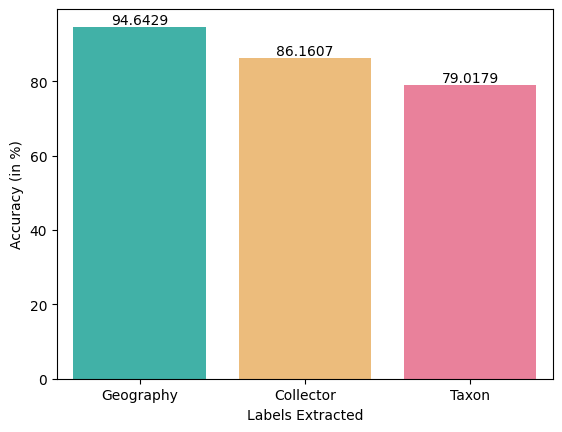

In [81]:
df_scores = pd.DataFrame({
        'Labels Extracted': ['Geography', 'Collector', 'Taxon'],
        'Accuracy (in %)': [geo_acc, col_acc, tax_acc]
})

df_scores = df_scores.sort_values(['Accuracy (in %)'], ascending=False).reset_index(drop=True)
# who v/s fare barplot 
palette=["#2ec4b6","#ffbf69","#fb6f92"]
ax = sns.barplot(x = 'Labels Extracted',
            y = 'Accuracy (in %)',
           data = df_scores,
           hue = 'Labels Extracted',
           palette=palette)

for i in ax.containers:
    ax.bar_label(i,)
# Show the plot
plt.show()

In [82]:
# fig = plt.get_figure()
ax.figure.savefig("scores.png") 